In [1]:
import matplotlib.pyplot as plt
# The line below allows to print all the outputs of a cell instead of only the last one
%config InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import os
import pandas as pd
# noinspection PyPackageRequirements
# noinspection PyPackageRequirements
import seaborn as sns
import sys
# noinspection PyPackageRequirements

import yaml

import pickle
import pathlib

2023-11-29 13:01:32.957081: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-29 13:01:33.044083: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-29 13:01:33.047405: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-11-29 13:01:33.047415: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not ha

In [2]:
from_script = False

print(f"WARNING: This notebook is set with from_script = {from_script}.")

if from_script:
    # Get the path of the notebook config file from the environment variable
    path_config_notebook = os.environ["PATH_YAML_CONFIG"]
    # Load the notebook config file
    with open(path_config_notebook, "r") as file:
        dict_config_notebook = yaml.safe_load(file)
    id_xp = dict_config_notebook["id_xp"]
    path_project = pathlib.Path(dict_config_notebook["path_project"])
else:
    id_xp = 16
    path_project = pathlib.Path("/home/hosseinkhan/Documents/work/phd/git_repositories/doe4rl")

# Add the path of the project to the sys.path in order to import the modules in the src folder
sys.path.insert(0, os.path.abspath(path_project))

# Define the paths
path_mlruns = pathlib.Path(f"{path_project}/experiments/mlruns")
path_experiment = pathlib.Path(f"{path_mlruns}/{id_xp}")
# Get all folder in the mlruns/id_xp directory except the folder 'tags' using pathlib and iter dir
list_id_hash = [path.name for path in path_experiment.iterdir() if path.is_dir() and path.name != "tags"]

print(f"Number of runs: {len(list_id_hash)} \n")
print(f"XP id: {id_xp} \n")

nested_dict_config = {}
list_df_config_flattened = []
# Verify all experiments are done on the same environment:
path_xp = f"{path_mlruns}/{id_xp}"
for name_id in list_id_hash:
    list_glob_config = list(pathlib.Path(f"{path_xp}/{name_id}/artifacts/hydra_config").glob("./*/.hydra/config.yaml"))
    assert len(list_glob_config) == 1, "More than one config file in the directory."

    name_config_file = list_glob_config[0].name
    # Check if the file is a yaml file
    assert name_config_file.endswith(".yaml"), "File is not a yaml file."

    path_run_config_yaml = list_glob_config[0]
    with open(path_run_config_yaml, "r") as file:
        # Get the config file as a dictionary
        dict_config_temp = yaml.safe_load(file)
        # Add the config file to the nested dictionary
        nested_dict_config[name_id] = dict_config_temp
        # Flatten the config file for easier check
        list_df_config_flattened.append(pd.json_normalize(dict_config_temp, sep="_"))
    del dict_config_temp

# Check afterwards if all the configurations are the same
set_expected_nonunique_keys = {"alg_num_iters",
                               "crop_to_domain",
                               "project_to_domain",
                               "alg_n_semimarkov_dt",
                               "seed",
                               "name"}

set_nonunique_keys = set(pd.concat(list_df_config_flattened)
                         .astype(str)
                         .nunique()
                         .loc[lambda x: x > 1]
                         .to_dict()
                         .keys())

print(f"Set of non unique keys: {set_nonunique_keys} \n")

# Check if the configurations are the same inter runs
bool_similar_configs = set_nonunique_keys.issubset(set_expected_nonunique_keys)
assert bool_similar_configs, "The configurations are not the same."

# Pretty print the first config file
print(f"First config file: {list_id_hash[0]} \n")
print(yaml.dump(nested_dict_config[list_id_hash[0]], sort_keys=False))

Number of runs: 15 

XP id: 16 

Set of non unique keys: {'alg_n_semimarkov_dt', 'seed'} 

First config file: db21257f53994180a233025af50bd84c 

name: 2023_11_28_xp_pendulum_semimarkov_new_project_to_domain
num_eval_trials: 5
eval_frequency: 1
resume: false
env:
  teleport: false
  normalize_env: true
  sample_exe: false
  gp:
    periodic: false
    opt_max_iter: 10
    ls:
    - - 272.74
      - 8.24
      - 172.12
    - - 0.04
      - 1.9
      - 75.03
    alpha:
    - 0.03
    - 13.94
    sigma: 0.0011
  tf_precision: 64
  name: bacpendulum-semimarkov-new-v0
  mpc:
    nsamps: 25
    planning_horizon: 20
    n_elites: 3
    beta: 3
    gamma: 1.25
    xi: 0.3
    num_iters: 1
    actions_per_plan: 1
  eigmpc:
    nsamps: 25
    planning_horizon: 15
    n_elites: 3
    beta: 3
    gamma: 1.25
    xi: 0.3
    num_iters: 1
    actions_per_plan: 1
  environment_parameters:
    dict_pde_config:
      ep_length: 200
      dt: 0.05
    dict_init_condition_config:
      init_cond_type: equ

# Drop inplace the data with seed 0 and 3
list_id_hash = [name_id for name_id in list_id_hash if nested_dict_config[name_id]["seed"] not in [0, 3]]


In [3]:
(pd.concat(list_df_config_flattened, keys=list_id_hash)
 .astype(str)
 .groupby(["seed", "alg_n_semimarkov_dt"])
 .nunique()
 # .loc[lambda x: x > 1]
 )

name  num_eval_trials  eval_frequency  resume  \
seed alg_n_semimarkov_dt                                                  
0    2                       1                1               1       1   
     4                       1                1               1       1   
1    1                       1                1               1       1   
     2                       1                1               1       1   
2    1                       1                1               1       1   
     2                       1                1               1       1   
3    1                       1                1               1       1   
     2                       1                1               1       1   
     4                       1                1               1       1   
4    1                       1                1               1       1   
     2                       1                1               1       1   
     4                       1                1               1       1   

                          num_iters  eval_bayes_policy  fixed_start_obs  \
seed alg_n_semimarkov_dt                                                  
0    2                            1                  1                1   
     4                            1                  1                1   
1    1                            1                  1                1   
     2                            1                  1                1   
2    1                            1                  1                1   
     2                            1                  1                1   
3    1                            1                  1                1   
     2                            1                  1                1   
     4                            1                  1                1   
4    1                            1                  1                1   
     2                            1                  1                1   
     4                            1                  1                1   

                          num_samples_mc  num_init_data  test_set_size  ...  \
seed alg_n_semimarkov_dt                                                ...   
0    2                                 1              1              1  ...   
     4                                 1              1              1  ...   
1    1                                 1              1              1  ...   
     2                                 1              1              1  ...   
2    1                                 1              1              1  ...   
     2                                 1              1              1  ...   
3    1                                 1              1              1  ...   
     2                                 1              1              1  ...   
     4                                 1              1              1  ...   
4    1                                 1              1              1  ...   
     2                                 1              1              1  ...   
     4                                 1              1              1  ...   

                          eigmpc_actions_per_plan  test_mpc_nsamps  \
seed alg_n_semimarkov_dt                                             
0    2                                          1                1   
     4                                          1                1   
1    1                                          1                1   
     2                                          1                1   
2    1                                          1                1   
     2                                          1                1   
3    1                                          1                1   
     2                                          1                1   
     4                                          1                1   
4    1                                         

In [4]:
list_name_columns_learning = ["Acquisition Function Value",
                              "Eval Returns",
                              "Eval ndata",
                              "mean_difference_state_boostrap",
                              "n_corresponding_dt",
                              "Model MSE (current real MPC)",
                              "Model MSE (random test set)",
                              "Model MSE (GT MPC)",
                              "Model Likelihood (random test set)",
                              "Model Likelihood (GT MPC)", ]

dict_columns_learning_renaming_map = {"Acquisition Function Value": "eig",
                                      "Eval Returns": "eval_returns",
                                      "Eval ndata": "eval_ndata",
                                      "mean_difference_state_boostrap": "mean_difference_state_bootstrap",
                                      "Model MSE (current real MPC)": "model_mse_current_real_mpc",
                                      "Model MSE (random test set)": "model_mse_random_test_set",
                                      "Model MSE (GT MPC)": "model_mse_gt_mpc",
                                      "Model Likelihood (random test set)": "model_likelihood_random_test_set",
                                      "Model Likelihood (GT MPC)": "model_likelihood_gt_mpc", }

# Load each of the runs data
list_df_learning_data = []

for name_id in list_id_hash:
    path_pickle_data = f"{path_experiment}/{name_id}/barl_data/info.pkl"
    # list(path_experiment.iterdir())[0]

    # Load the data
    with open(path_pickle_data, "rb") as file:
        dict_data = pickle.load(file)

    df_learning_data_temp = (
        pd.DataFrame({name_columns: dict_data[name_columns] for name_columns in list_name_columns_learning})
        .explode("Eval Returns")
        .reset_index(names=["iteration"])
        .rename(columns=dict_columns_learning_renaming_map)
    )

    list_df_learning_data.append(df_learning_data_temp)

In [5]:
# Get the list of the delay mode
list_action_delay_mode = [nested_dict_config[name_id]["alg"]["n_semimarkov_dt"]
                          for name_id in list_id_hash]

list_keys_tuple_id_action_delay_mode = [(run_id, action_delay_mode)
                                        for run_id, action_delay_mode
                                        in zip(list_id_hash, list_action_delay_mode)]

df_learning_data = pd.concat(list_df_learning_data, keys=list_keys_tuple_id_action_delay_mode,
                             names=["run_id", "action_delay_mode"])

In [6]:
df_learning_data.describe()

,iteration,eig,eval_ndata,mean_difference_state_bootstrap,n_corresponding_dt,model_mse_current_real_mpc,model_mse_random_test_set,model_mse_gt_mpc,model_likelihood_random_test_set,model_likelihood_gt_mpc
count,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,49.500000,2.015834,50.500000,1.461276e-02,1.985333,0.006141,0.006392,0.011369,-1.838536,-1.839251
std,28.867995,1.449502,28.867995,6.771184e-02,1.145990,0.019878,0.001938,0.035902,0.000377,0.002774
min,0.000000,0.412910,1.000000,0.000000e+00,1.000000,0.000028,0.004398,0.000187,-1.840863,-1.866434
25%,24.750000,1.017038,25.750000,1.387779e-17,1.000000,0.000592,0.005460,0.000933,-1.838520,-1.839257
50%,49.500000,1.518158,50.500000,1.369515e-04,2.000000,0.001364,0.006061,0.001571,-1.838415,-1.838408
75%,74.250000,2.695068,75.250000,1.588096e-03,2.000000,0.004612,0.006802,0.010005,-1.838349,-1.838166
max,99.000000,9.406612,100.000000,9.683179e-01,4.000000,0.256817,0.025924,0.428276,-1.838210,-1.837996


In [7]:
n_eval_trajectory = nested_dict_config[list_id_hash[0]]["num_eval_trials"]

(df_learning_data
 .reset_index(level=-1)
 .assign(trajectory_id=lambda df: df["level_2"] % n_eval_trajectory)
 .drop(columns=["level_2"]))

iteration       eig  \
run_id                           action_delay_mode                        
db21257f53994180a233025af50bd84c 1                          0  5.227058   
                                 1                          0  5.227058   
                                 1                          0  5.227058   
                                 1                          0  5.227058   
                                 1                          0  5.227058   
...                                                       ...       ...   
29ae7896a57942ae97093fd8b291649d 4                         99  0.858320   
                                 4                         99  0.858320   
                                 4                         99  0.858320   
                                 4                         99  0.858320   
                                 4                         99  0.858320   

                                                   eval_returns  eval_ndata  \
run_id                           action_delay_mode                            
db21257f53994180a233025af50bd84c 1                  -987.709713         1.0   
                                 1                 -1469.006542         1.0   
                                 1                 -1478.126759         1.0   
                                 1                 -1453.459876         1.0   
                                 1                 -1025.603486         1.0   
...                                                         ...         ...   
29ae7896a57942ae97093fd8b291649d 4                  -211.504187       100.0   
                                 4                  -234.984866       100.0   
                                 4                  -201.787371       100.0   
                                 4                   -246.83996       100.0   
                                 4                  -203.996932       100.0   

                                                    mean_difference_state_bootstrap  \
run_id                           action_delay_mode                                    
db21257f53994180a233025af50bd84c 1                                              0.0   
                                 1                                              0.0   
                                 1                                              0.0   
                                 1                                              0.0   
                                 1                                              0.0   
...                                                                             ...   
29ae7896a57942ae97093fd8b291649d 4                                              0.0   
                                 4                                              0.0   
                                 4                                              0.0   
                                 4                                              0.0   
                                 4                                              0.0   

                                                    n_corresponding_dt  \
run_id                           action_delay_mode                       
db21257f53994180a233025af50bd84c 1                                 1.0   
                                 1                                 1.0   
                                 1                                 1.0   
                                 1                                 1.0   
                                 1                                 1.0   
...                                                                ...   
29ae7896a57942ae97093fd8b291649d 4                                 1.0   
                                 4                                 1.0   
                                 4                                 1.0   
                                 4                                 1.0   
                            

import seaborn as sns
import numpy as np
palette = sns.color_palette("Blues", 3 - 1)
# Increase darkness of all colors in palette
coeff_darkness = 1.0
palette = sns.color_palette([tuple(coeff_darkness * np.array(color)) for color in palette])
palette

import seaborn as sns
import numpy as np
sns_other_palette = sns.color_palette("Blues", 3 - 1)
# Increase darkness of all colors in palette
coeff_darkness = 0.5
sns_other_palette = sns.color_palette([tuple(coeff_darkness * np.array(color)) for color in sns_other_palette])
list_color_palette = ["black"] + sns_other_palette

list_color_palette

In [8]:
# Generate color palette with the first control experiment (no delay) being black while the others are Green but quite dark to be able to distinguish them
sns_other_palette = sns.color_palette("Reds", len(set(list_action_delay_mode)) - 1)
# Increase darkness of all colors in palette
coeff_darkness = 0.8
sns_other_palette = sns.color_palette([tuple(coeff_darkness * np.array(color)) for color in sns_other_palette])
list_color_palette = ["Grey"] + sns_other_palette
# list_color_palette = ["black"] + sns.color_palette("Greens", len(list_action_delay_mode) - 1).as_hex()
df_plot = df_learning_data.reset_index()

list_columns_plot = ["eig", "eval_returns", "mean_difference_state_bootstrap", "n_corresponding_dt",
                     "model_mse_current_real_mpc", "model_mse_random_test_set",
                     "model_mse_gt_mpc", "model_likelihood_random_test_set", "model_likelihood_gt_mpc", "eval_ndata"]

plt.close()
for name_column in list_columns_plot:
    print(f"================== {name_column} ==================")
    g = sns.lineplot(data=df_plot,
                     x="iteration",
                     y=name_column,
                     hue="action_delay_mode",
                     errorbar="sd",
                     legend="full",
                     palette=list_color_palette)
    # plt.show()
    # Save the figure
    g.figure.savefig(f"/home/hosseinkhan/Downloads/temp_imgs/{name_column}.png")
    plt.close()

================== eig ==================
================== eval_returns ==================
================== mean_difference_state_bootstrap ==================
================== n_corresponding_dt ==================
================== model_mse_current_real_mpc ==================
================== model_mse_random_test_set ==================
================== model_mse_gt_mpc ==================
================== model_likelihood_random_test_set ==================
================== model_likelihood_gt_mpc ==================
================== eval_ndata ==================


In [9]:
dim_x = len(nested_dict_config[list_id_hash[0]]["env"]["gp"]["alpha"])
dim_u = len(nested_dict_config[list_id_hash[0]]["env"]["gp"]["ls"][0]) - dim_x

list_df_trajectory_data = []

for name_id in list_id_hash:
    path_pickle_data = f"{path_experiment}/{name_id}/barl_data/info.pkl"

    # Load the data
    with open(path_pickle_data, "rb") as file:
        dict_data = pickle.load(file)

    df_learning_data_temp = (
        pd.DataFrame({name_columns: dict_data[name_columns] for name_columns in list_name_columns_learning})
        .explode("Eval Returns")
        .reset_index(names=["iteration"])
        .rename(columns=dict_columns_learning_renaming_map)
    )

    df_trajectory_data_temp = (pd.concat(
        [pd.DataFrame(np.array(dict_data["x"])[:, :dim_x]), pd.DataFrame(np.array(dict_data["x"])[:, dim_x:])],
        axis="columns",
        keys=["state", "action"],
        names=["component", "i"]).assign(n_corresponding_dt=[0] + list(np.array(dict_data["n_corresponding_dt"])),
                                         iteration=[0] + list(np.array(dict_data["n_corresponding_dt"]).cumsum())
                                         )
                               )

    list_df_trajectory_data.append(df_trajectory_data_temp)

In [11]:
df_trajectory_data = pd.concat(list_df_trajectory_data, keys=list_keys_tuple_id_action_delay_mode,
                               names=["run_id", "action_delay_mode"])

In [12]:
df_trajectory_data

component                                                  state            \
i                                                              0         1   
run_id                           action_delay_mode                           
db21257f53994180a233025af50bd84c 1                 0    0.001540 -0.004252   
                                                   1   -0.000158  0.023813   
                                                   2    0.000084  0.048443   
                                                   3    0.000457  0.074635   
                                                   4    0.000796  0.067740   
...                                                          ...       ...   
29ae7896a57942ae97093fd8b291649d 4                 96   0.039531 -0.067974   
                                                   97   0.039167 -0.072772   
                                                   98   0.038884 -0.056616   
                                                   99   0.037991 -0.033800   
                                                   100  0.037848 -0.028612   

component                                                 action  \
i                                                              0   
run_id                           action_delay_mode                 
db21257f53994180a233025af50bd84c 1                 0    0.670397   
                                                   1    0.688417   
                                                   2    0.681601   
                                                   3   -0.275299   
                                                   4    0.396546   
...                                                          ...   
29ae7896a57942ae97093fd8b291649d 4                 96  -0.075762   
                                                   97   0.410230   
                                                   98  -0.000943   
                                                   99  -0.116919   
                                                   100 -0.261615   

component                                              n_corresponding_dt  \
i                                                                           
run_id                           action_delay_mode                          
db21257f53994180a233025af50bd84c 1                 0                  0.0   
                                                   1                  1.0   
                                                   2                  1.0   
                                                   3                  1.0   
                                                   4                  1.0   
...                                                                   ...   
29ae7896a57942ae97093fd8b291649d 4                 96                 1.0   
                                                   97                 1.0   
                                                   98                 1.0   
                                                   99                 4.0   
                                                   100                1.0   

component                                              iteration  
i                                                                 
run_id                           action_delay_mode                
db21257f53994180a233025af50bd84c 1                 0         0.0  
                                                   1         1.0  
                                                   2         2.0  
                                                   3         3.0  
                                                   4         4.0  
...                                                          ...  
29ae7896a57942ae97093fd8b291649d 4                 96      294.0  
                                                   97      295.0  
                                                   98      296.0  
                                                   99      300.0  
    

In [13]:
df_trajectory_data.describe()

component        state                    action n_corresponding_dt  \
i                    0            1            0                      
count      1515.000000  1515.000000  1515.000000        1515.000000   
mean         -0.006578    -0.009513     0.015238           1.965677   
std           0.090023     0.418003     0.565486           1.157428   
min          -0.306225    -1.000000    -0.999936           0.000000   
25%          -0.038127    -0.260167    -0.412537           1.000000   
50%           0.018542    -0.010770     0.028816           2.000000   
75%           0.042712     0.234441     0.468642           2.000000   
max           0.233516     0.972547     0.999900           4.000000   

component    iteration  
i                       
count      1515.000000  
mean        105.375578  
std          82.192790  
min           0.000000  
25%          41.000000  
50%          83.000000  
75%         156.000000  
max         345.000000

In [14]:
df_trajectory_data["state", 0] *= 80
df_trajectory_data["state", 1] *= 8

df_trajectory_data["action", 0] *= 2


In [15]:
df_trajectory_data.describe()

component        state                    action n_corresponding_dt  \
i                    0            1            0                      
count      1515.000000  1515.000000  1515.000000        1515.000000   
mean         -0.526233    -0.076102     0.030476           1.965677   
std           7.201821     3.344026     1.130973           1.157428   
min         -24.497960    -8.000000    -1.999872           0.000000   
25%          -3.050184    -2.081339    -0.825075           1.000000   
50%           1.483347    -0.086160     0.057632           2.000000   
75%           3.416924     1.875530     0.937283           2.000000   
max          18.681312     7.780374     1.999800           4.000000   

component    iteration  
i                       
count      1515.000000  
mean        105.375578  
std          82.192790  
min           0.000000  
25%          41.000000  
50%          83.000000  
75%         156.000000  
max         345.000000

In [16]:
(df_trajectory_data
 .set_index(["n_corresponding_dt", "iteration"], append=True)
 .stack(level=["component", "i"])
 .rename("system_value")
 .reset_index()
 .drop(columns="level_2"))

,run_id,action_delay_mode,n_corresponding_dt,iteration,component,i,system_value
0,db21257f53994180a233025af50bd84c,1,0.0,0.0,action,0,1.340794
1,db21257f53994180a233025af50bd84c,1,0.0,0.0,state,0,0.123236
2,db21257f53994180a233025af50bd84c,1,0.0,0.0,state,1,-0.034014
3,db21257f53994180a233025af50bd84c,1,1.0,1.0,action,0,1.376835
4,db21257f53994180a233025af50bd84c,1,1.0,1.0,state,0,-0.012645
...,...,...,...,...,...,...,...
4540,29ae7896a57942ae97093fd8b291649d,4,4.0,300.0,state,0,3.039305
4541,29ae7896a57942ae97093fd8b291649d,4,4.0,300.0,state,1,-0.270403
4542,29ae7896a57942ae97093fd8b291649d,4,1.0,301.0,action,0,-0.523230
4543,29ae7896a57942ae97093fd8b291649d,4,1.0,301.0,state,0,3.027860


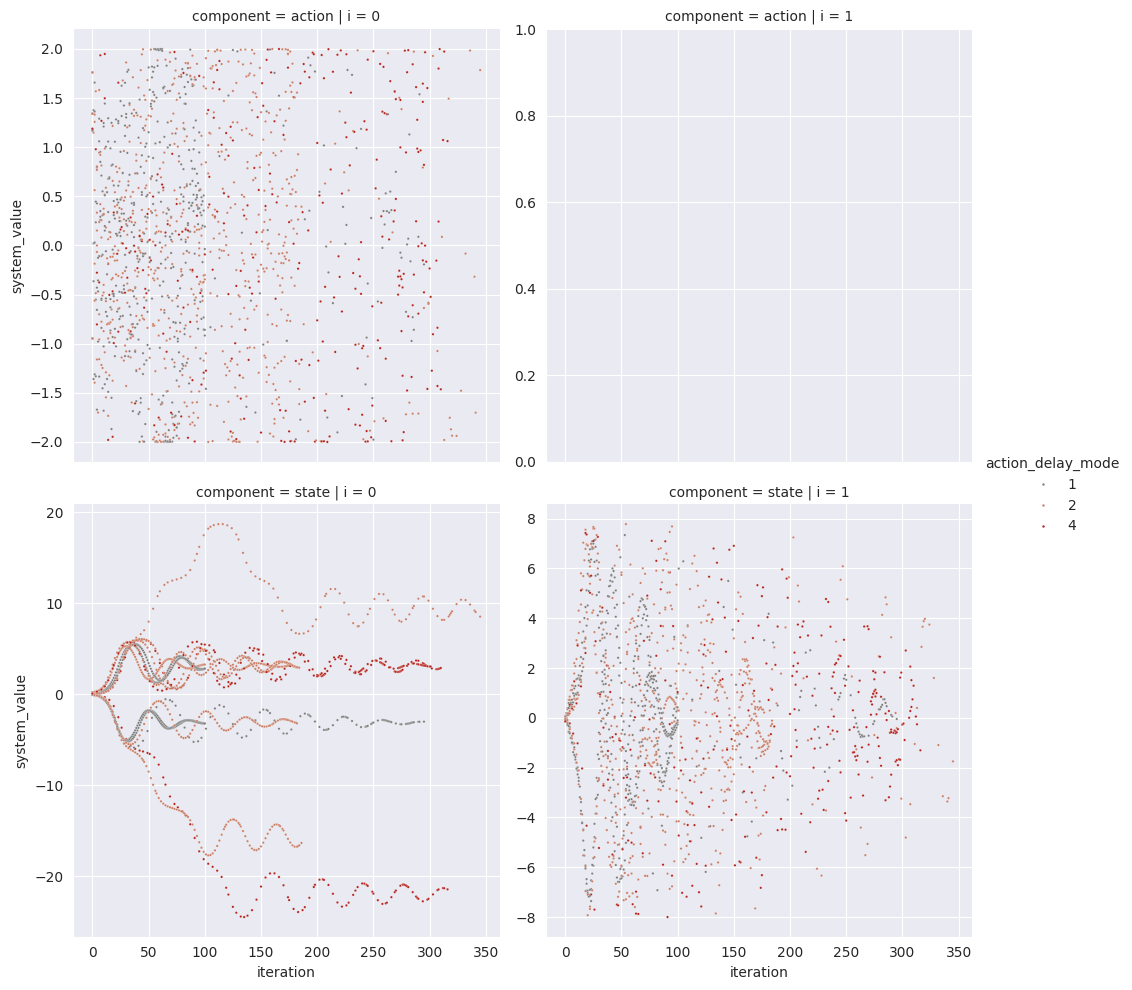

In [17]:
df_temp = (df_trajectory_data
           .set_index(["n_corresponding_dt", "iteration"], append=True)
           .stack(level=["component", "i"])
           .rename("system_value")
           .reset_index()
           .drop(columns="level_2"))

sns.relplot(data=df_temp,
            x="iteration",
            y="system_value",
            hue="action_delay_mode",
            col="i",
            row="component",
            # kind="line",
            # no sharing of y axis rowwise
            facet_kws=dict(sharey=False),
            # reduce size of markers
            palette=list_color_palette,
            s=3, )

##### Action distribution along time

/tmp/ipykernel_29147/1998059645.py:2: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_temp = (df_trajectory_data


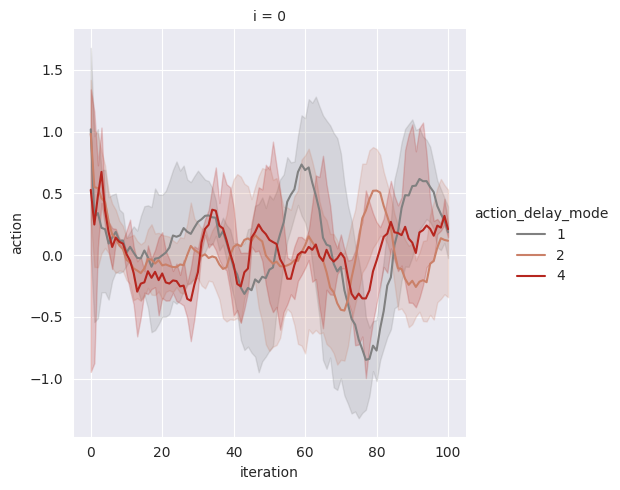

In [18]:
window_size = 10
df_temp = (df_trajectory_data
           .loc[pd.IndexSlice[:, :, :], ["action"]]
           .groupby(["run_id", "action_delay_mode"], as_index=False)
           .rolling(window=window_size, min_periods=1)
           .mean()
           .drop(columns=["run_id", "action_delay_mode"])
           .stack(level=-1)
           .reset_index()
           .rename(columns={"level_2": "iteration"}))

# Plot the time series
sns.relplot(data=df_temp,
            x="iteration",
            y="action",
            hue="action_delay_mode",
            col="i",
            kind="line",
            # no sharing of y axis rowwise
            facet_kws=dict(sharey=False),
            # reduce size of markers
            palette=list_color_palette,
            # s=3,
            )

In [19]:
(df_trajectory_data
 .set_index(["n_corresponding_dt", "iteration"], append=True)
 .stack(level=["component", "i"])
 .rename("system_value")
 .reset_index()
 .drop(columns="level_2"))

,run_id,action_delay_mode,n_corresponding_dt,iteration,component,i,system_value
0,db21257f53994180a233025af50bd84c,1,0.0,0.0,action,0,1.340794
1,db21257f53994180a233025af50bd84c,1,0.0,0.0,state,0,0.123236
2,db21257f53994180a233025af50bd84c,1,0.0,0.0,state,1,-0.034014
3,db21257f53994180a233025af50bd84c,1,1.0,1.0,action,0,1.376835
4,db21257f53994180a233025af50bd84c,1,1.0,1.0,state,0,-0.012645
...,...,...,...,...,...,...,...
4540,29ae7896a57942ae97093fd8b291649d,4,4.0,300.0,state,0,3.039305
4541,29ae7896a57942ae97093fd8b291649d,4,4.0,300.0,state,1,-0.270403
4542,29ae7896a57942ae97093fd8b291649d,4,1.0,301.0,action,0,-0.523230
4543,29ae7896a57942ae97093fd8b291649d,4,1.0,301.0,state,0,3.027860


,run_id,action_delay_mode,n_corresponding_dt,iteration,component,i,system_value
1,db21257f53994180a233025af50bd84c,1,0.0,0.0,state,0,0.123236
2,db21257f53994180a233025af50bd84c,1,0.0,0.0,state,1,-0.034014
4,db21257f53994180a233025af50bd84c,1,1.0,1.0,state,0,-0.012645
5,db21257f53994180a233025af50bd84c,1,1.0,1.0,state,1,0.190505
7,db21257f53994180a233025af50bd84c,1,1.0,2.0,state,0,0.006733
...,...,...,...,...,...,...,...
4538,29ae7896a57942ae97093fd8b291649d,4,1.0,296.0,state,1,-0.452932
4540,29ae7896a57942ae97093fd8b291649d,4,4.0,300.0,state,0,3.039305
4541,29ae7896a57942ae97093fd8b291649d,4,4.0,300.0,state,1,-0.270403
4543,29ae7896a57942ae97093fd8b291649d,4,1.0,301.0,state,0,3.027860


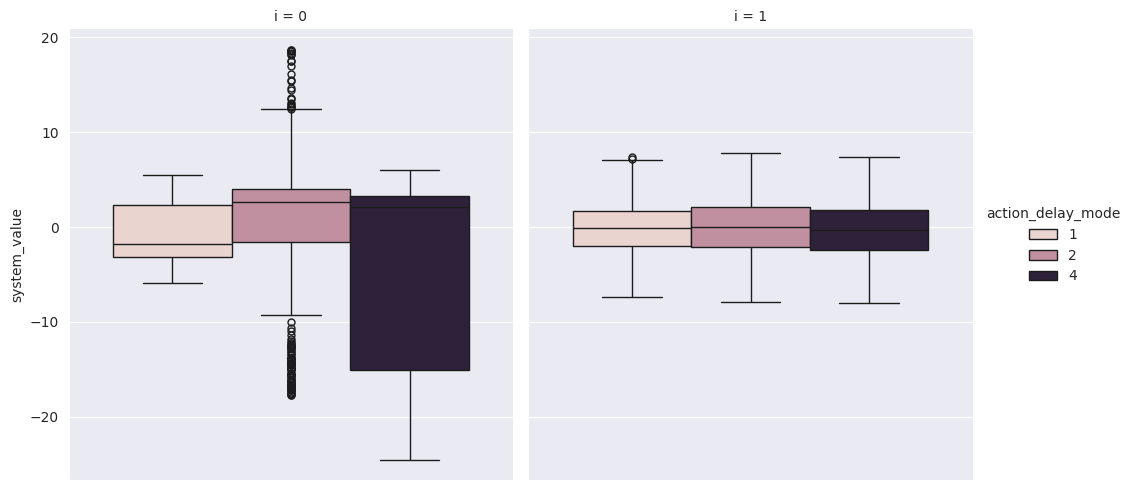

In [20]:
df_temp = (df_trajectory_data
.set_index(["n_corresponding_dt", "iteration"], append=True)
.stack(level=["component", "i"])
.rename("system_value")
.reset_index()
.drop(columns="level_2")
# Extract only the state
.loc[lambda df: df["component"] == "state"]
)

# Plot the statistics with boxplot
sns.catplot(data=df_temp,
            col="i",
            y="system_value",
            hue="action_delay_mode",
            # col="i",
            # col="component",
            # row="statistic",
            # kind="line",
            # no sharing of y axis rowwise
            # sharey=False,
            # facet_kws=dict(sharey=False),
            # common_bins=False,
            kind="box",
            # bins=50
            # reduce size of markers
            # s=3,
            )